In [8]:
%pylab inline
import pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [9]:
df = pd.read_pickle('data/traffic_preprocessed.pkl')
df.head()

hour  month  id_arc_trafic   AVG(debit)  AVG(taux)  \
id_arc_trafic                                                           
1             0       0      1              1  1188.714286   4.638207   
              93      0      2              1  1261.829268   5.031917   
              186     0      3              1  1468.347826   4.730384   
              79      0      4              1  1106.285714   5.214193   
              165     0      5              1  1452.818182   6.927379   

                         lat       lon   lndebit  time  dlo25  dla25  dlo50  \
id_arc_trafic                                                                 
1             0    48.859838  2.334242  4.121122   100     13     12     25   
              93   48.859838  2.334242  4.170615   200     13     12     25   
              186  48.859838  2.334242  4.298984   300     13     12     25   
              79   48.859838  2.334242  4.062314   400     13     12     25   
              165  48.859838  2.334242  4.289851   500     13     12     25   

                   dla50  dlo75  dla75  
id_arc_trafic                           
1             0       24     38     37  
              93      24     38     37  
              186     24     38     37  
              79      24     38     37  
              165     24     38     37

In [10]:
#coarse graining
df2 = df.groupby(['hour','month','dlo25','dla25']).agg({'AVG(debit)':'sum','AVG(taux)':'mean','lat':'mean','lon':'mean','time':'mean'})
df2.columns = df2.columns.get_level_values(0)
df2.head()
# or no coarse graining
df2 =df

In [11]:
x = df.groupby('id_arc_trafic')['AVG(debit)'].max()

/home/home/astyonax/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 'id_arc_trafic' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


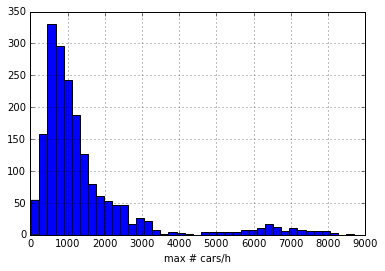

In [18]:
x.hist(bins=40)
plt.gca().set_xlabel("max # cars/h")
plt.savefig('figures/histogram_counts.png',bbox_inches='tight',dpi=96)

In [13]:
def xx (x):
    if x['AVG(debit)'].max()<3500:
        return x    
blue = df.groupby('id_arc_trafic').apply(xx)
#------------------------------------------#
def xx (x):
    if x['AVG(debit)'].max()>3500:
        return x
red = df.groupby('id_arc_trafic').apply(xx)
#------------------------------------------#

/home/home/astyonax/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: 'id_arc_trafic' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
/home/home/astyonax/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: 'id_arc_trafic' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


In [14]:
# Save for visualization
red.to_hdf('data/split_perif_inner.h5','periferique')
blue.to_hdf('data/split_perif_inner.h5','inner')


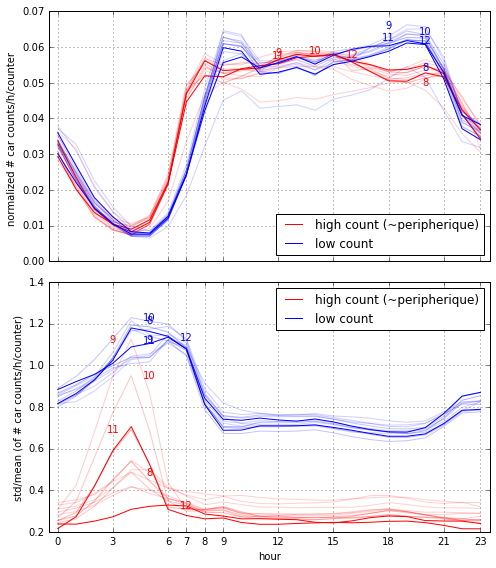

In [19]:
def fa(t):
    return (t*(11-t)+1.)**.5
def nfa(t):
    
    return 2*((t%2)-.5)

def plot_cicle(data,axis,color,norm=False,label=''):
    x = data.groupby('time')['AVG(debit)'].sum()
    x /= x.sum()/12.
    DT=24
    
    t=0
    sl = slice(t*24,24+t*24)
    B = x.values[sl]
    axis.plot(range(0,24),B,lw=1,c=color,label=label)
    
    for t in xrange(1,12):
        sl = slice(t*24,24+t*24)
        B = x.values[sl]
        axis.plot(range(0,24),B,lw=1,c=color,alpha=1./fa(t))
        if t >=7:
            Y=B.max()
            X=np.argmax(B)
            axis.text(X+nfa(t),Y,'{0:d}'.format(t+1),ha='center',va='center',fontsize=10,color=color)
    axis.grid(1)
    
# KISS this time
def plot_cicle2(data,axis,color,norm=False,label=''):
    q = data.groupby('time')['AVG(debit)']
    x = q.std()/q.mean()
    DT=24
    
    t=0
    sl = slice(t*24,24+t*24)
    B = x.values[sl]
    if norm: B/=B.sum()
    axis.plot(range(0,24),B,lw=1,c=color,label=label)
    
    for t in xrange(1,12):
        sl = slice(t*24,24+t*24)
        B = x.values[sl]
        if norm: B/=B.sum()
    #     B = B.cumsum()
        axis.plot(range(0,24),B,lw=1,c=color,alpha=1./fa(t))
        
        if t >=7:
            Y=B.max()
            X=np.argmax(B)
            axis.text(X+nfa(t),Y,'{0:d}'.format(t+1),ha='center',va='center',fontsize=10,color=color)
    axis.grid(1)
    
fig,(ax,bx) = plt.subplots(2,1,figsize=(7,8),sharex='all')
plot_cicle(red,ax,'r',0,'high count (~peripherique)')
plot_cicle(blue,ax,'b',0,'low count')
ax.set_ylabel('normalized # car counts/h/counter ')
ax.set_xlim(-.5,23.5)
ax.legend(loc='best')

plot_cicle2(red,bx,'r',False,'high count (~peripherique)')
plot_cicle2(blue,bx,'b',False,'low count')
bx.set_xlabel('hour')
bx.set_ylabel('std/mean (of # car counts/h/counter)')
bx.xaxis.set_ticks([0,3,6,7,8,9,12,15,18,21,23])
bx.set_xlim(-.5,23.5)
bx.legend(loc=1)
fig.tight_layout()
fig.savefig('figures/perifvscity.png',bbox='tight',dpi=96)